<center>
    <h2>SENG 474 Project</h2>
    <h1><i>Mood in Music: An Analysis of User-generated Spotify Playlists</i></h1>
    <h4>Lily Bryant (V00831776), Samantha Lai (V00846643), Shirley Wang (V00828517)</h4>
    <br><i>November 2018</i>
</center>
___

## Abstract

words

## Contents

<pre>
<b>1 Introduction</b>
<b>2 Related Work</b>
<b>3 Data Preprocessing</b>
    3.1 Set-up and Authorization
    3.2 Data Gathering
    3.3 WEKA
<b>4 Visualization</b>
    4.1 Set-up and Data Formatting
    4.2 Attribute Heatmap
    4.3 Attribute Box Plots
    4.4 Comparison Scatter Plots
<b>5 Data Mining</b>
    5.1 Naive Bayes
    5.2 Trees
    5.3 Logistic Regression
    5.4 IBK
    5.5 Ada Boost
<b>6 Evaluation
7 Conclusion
8 References</b>
</pre>




## 1 Introduction

With over 30 million songs and 2 billion playlists from around the world, Spotify is a music streaming platform that processes and stores an immense amount of musical data [1]. The extent of its global influence can be seen from the over 180 million monthly users from countries in Europe, the Americas, Oceania, and parts of Africa and Asia. From hit lists of the very most popular current songs to weekly tailored playlists for users, Spotify has a wealth of data and takes advantage of this by utilizing many data mining and machine learning algorithms to analyze every song [2]. Part of their song analysis involves breaking down each song into bar by bar information, such as rhythm and pitch. This precise processing results in various 'scores', such as a song's danceability or acousticness, which is then used for their recommendation system. Through the Spotify API for developers [2], all of this song information is available publicly for free.

The analysis of each song’s features is extremely valuable for predictions and, together with the user-generated data, allows data scientists to gain insight into music patterns. Users save songs they enjoy and, perhaps more importantly, group like songs together in playlists. By examining the typical attributes of songs in a type of playlist, it is possible to learn interesting patterns about the prototypical song of the playlist – that is, what aspects of the song make it more likely to be featured in that playlist.

One interesting area of analysis in music is the mood or energy a song has. A cheery, upbeat song might have an exciting energy and remind you of a summer day, while a calm, relaxing song may make you sleepy and want to curl up with a book. But how do we quantify this? What makes a song sound upbeat versus calm? Using Spotify's audio analysis scoring system and user-generated playlists containing keywords relating to this contrast, we will build classification models to hopefully answer this question.

## 2 Related Work

Spotify provides a web API for developer use [3]. Developers are able to register their applications through Spotify, so they may access song, playlist, and user data. Many other projects have used the API to attain song data. Three were examined to provide insight to its use and possibilities: “Finding Emotion in Music with Python” [4], “Analyzing Spotify API Song Data Pt. 1” [5], and “Spotify Music Data Analysis” [6].

“Finding Emotion in Music with Python” used Spotify data to train a model for predicting whether a song was ‘happy’ or ‘sad’ [4]. Using the song attributes data, Vollebregt gathered the ‘valence’ and ‘energy’ values for songs in playlists user-labelled as ‘happy’ or ‘sad’, and observed a relationship between the attributes and songs with these labels.

The attributes of jazz, rock, and hip-hop songs were explored in “Analyzing Spotify API Song Data Pt. 1” [5]. Song attributes ‘danceability,’ ‘acousticness,’ and ‘valence’ were plotted in 2- and 3-D space to view the differences in the attributes in these genres. This exploration took extra steps in preprocessing to ease data collection.
“Spotify Music Data Analysis” examined trends in music over the past 20 years [6]. Song attributes, artist information, and album data were gathered for each track, and used to sort the tracks by release year, examine trends in song attributes, and analyze genre popularity. 

Since the project was coded in Python, the Spotipy library was used to simplify data access [7]. Spotipy’s library allows users to use Spotify’s API and provides some examples of use; of the projects examined, “Finding Emotion in Music with Python” also relied on the Spotipy library [4].


## 3 Data Preprocessing

### 3.1 Spotify API Set-up and Authorization

In order to gain access to the Spotify Web API, we created a developer account and registered our application through the Spotify dashboard. This created a client ID (a unique identifier of the application) and a client secret (a key that is passed in during secure calls to the Spotify Accounts and Web API services), which we could use to obtain an authorization token.

In the code below, we imported the necessary libraries and got an access token with a Spotipy function to authenticate calls to the Spotify API.

In [75]:
import sys
import os
import spotipy
import spotipy.util as util

SPOTIPY_CLIENT_ID='b0b5be645e864041a2fad5d7ccdf0531'
SPOTIPY_CLIENT_SECRET='86078e2a70f0476e9ec2785ed822b05e'

token = util.oauth2.SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
cache_token = token.get_access_token()

spotify = spotipy.Spotify(auth=cache_token)

### 3.2 Data Gathering

The following code blocks utilize the Spotify API to pull detailed audio analysis of tracks. These tracks are found by searching for playlists which contain relevant search words. To look for meaningful patterns, our dataset is split into two categories: “upbeat” and “calm”. Each search category contains six keywords that were used to search Spotify for playlists. The upbeat category contains words that one might commonly associate with higher energy music (Figure 1), while the calm category contains those associated with lower energy music (Figure 2). Each keyword was searched on Spotify via the API and the top 5 playlist results were returned. Then, the detailed audio features from each track in playlist was stored. After collection, all track instances and their relevant features (Figure 3) were formatted and saved into data.csv.

| Keyword |
|---|---|
| upbeat |  |
| party |  |
| dance |  |
| energy |  |
| energetic |  |
| hype |  |

<br><center><b>Figure 1:</b> <i>upbeat keywords</i>, the list of "upbeat" words used for searching Spotify playlists</center>

| Keyword |
|---|---|
| calm |  |
| relax |  |
| chill |  |
| spa |  |
| sleep |  |
| peaceful |  |

<br><center><b>Figure 2:</b> <i>calm keywords</i>, is the list of "calm" words used for searching Spotify playlists</center>

| Attribute Name | Spotify API Description | Maximum | Minimum |
|---|---|
| danceability | How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. | 1.0 | 0.0| 
| energy | Features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. | 1.0 | 0.0 |
| key | Estimated overall key. Integers map to pitches using standard Pitch Class notation (0 = C, 1 = C♯/D♭, 2 = D, and so on.)  | 10 | 0 |
| loudness | Overall loudness of a track in decibels (dB) averaged across the entire track.  | 1.0 | 0.0 |
| mode | Modality (major or minor) of a track. | 1 (Major) | 0 (Minor) |
| speechiness | The presence of spoken words in a track. | 1.0 | 0.0 |
| acousticness | A confidence measure of whether the track is acoustic. | 1.0 | 0.0 |
| instrumentalness | Predicts whether a track contains no vocals.  | 1.0 | 0.0 |
| liveness | Detects the presence of an audience in the recording. | 1.0 | 0.0 |
| valence | Musical positiveness conveyed by a track. | 1.0 | 0.0 |
| tempo | Overall estimated tempo of a track in beats per minute (BPM). | 1750.0 | 0.0 |
| duration_ms | The duration of the track in milliseconds. | any | 0 |
| time_signature | Estimated overall time signature of a track. | any | 0 |
| mood | Our binary mood classification. | 1 (upbeat) | 0 (calm) |

<br><center><b>Figure 3:</b> <i>attributes</i>, the list of attributes used for classification where "mood" is the class value

In [ ]:
attribs = [
            "danceability",
            "energy",
            "key",
            "loudness",
            "mode",
            "speechiness",
            "acousticness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "duration_ms",
            "time_signature",
            "mood"
          ]

upbeat_keywords = [
            "upbeat",
            "party",
            "dance",
            "energy",
            "energetic",
            "hype",
]

calm_keywords = [
            "calm",
            "relax",
            "chill",
            "spa",
            "sleep",
            "peaceful",
]

In [ ]:
id_list = []

def get_tracks(search_term, lim, mood):
    tracks = []
    
    for p in spotify.search(search_term, limit=lim, offset=0, type='playlist', market='CA')["playlists"]["items"]:
        for t in spotify.user_playlist("spotify", p["id"])["tracks"]["items"]:
            t_id = t["track"]["id"]
            
            # append only new tracks
            if t_id not in id_list:
                id_list.append(t_id)        
                
                # skip tracks that API cannot find
                try:
                    info = spotify.audio_features(t_id)[0]
                except:
                    continue
                
                info["id"] = t_id
                info["mood"] = mood
                tracks.append(info)

        print("playlist completed for", search_term)
    return tracks

In [ ]:
upbeat_tracks = []
for word in upbeat_keywords:
    upbeat_tracks += get_tracks(word, 5, 1)

In [ ]:
calm_tracks = []
for word in calm_keywords:
    calm_tracks += get_tracks(word, 5, 0)

In [ ]:
data = upbeat_tracks + calm_tracks

In [ ]:
import csv

with open('data.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=attribs, extrasaction="ignore")

    writer.writeheader()
    for track in data:
        writer.writerow(track)

### 3.3 WEKA

- Import data.csv
- In the “Preprocess” tab:
    * Using unsupervised attribute filter NumericaltoNominal, apply to “mood” attribute to allow for discrete classification.
    * Using unsupervised attribute filter Normalize with scaling between 0 and 1, apply to all features for more meaningful visualization.
    * Export normalized dataset as data_normal.csv


## 4 Visualization

### 4.1 Set-up and Data Formatting

The following code blocks use Python libraries Pandas, MatPlotLib, and Seaborn to prepare the normalized raw dataset for visualization in the following sections.

In [78]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [100]:
df = pd.read_csv('data_normal.csv', encoding='unicode_escape')
df.head()

upbeat_df = df[df.mood == 1]
calm_df = df[df.mood == 0]

corr = dataset.corr()

### 4.2 Attribute Heatmap

Even before classification, we immediately see interesting patterns in our data. Energy, loudness, valence, and danceability show a high positive correlation with mood. Thus, higher scores in these attributes imply a track is more upbeat. Conversely, acousticness and instrumentalness show a large negative correlation indicating that these attributes result in a more calm sound overall. Further, we see that key, mode, time signature, and the duration of a track is nearly independent of mood. We also see some correlation between songs with more speech (speechiness) and faster tempo, as well as live tracks, being considered upbeat.

The heatmap below illustrates these patterns. Correlation coefficients are listed over corresponding attribute pairs.

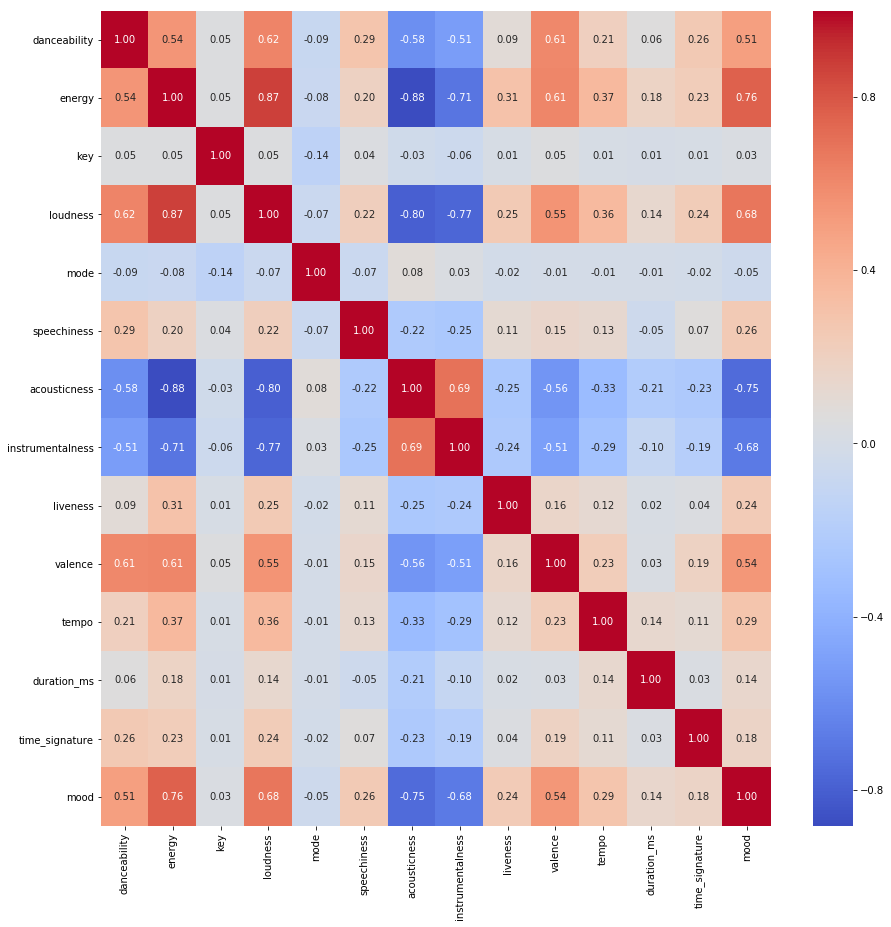

In [94]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

### 4.3 Attribute Box Plots

Below are box plots showing the attributes within each mood category. The plots correspond to upbeat and calm instances, respectively. As above, the attributes of danceability, energy, loudness, and valence have relatively high medians in the upbeat plot, while the calm plot shows low values. Even more noticeably, the contrast of high instrumentalness and acousticness scores in the calm plot against the upbeat plots illustrates how key these traits are in the making of a calm, relaxing sound.

* add figure references *

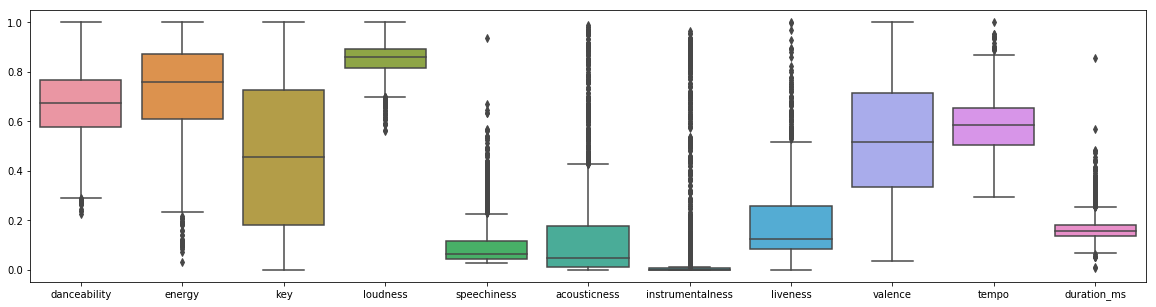

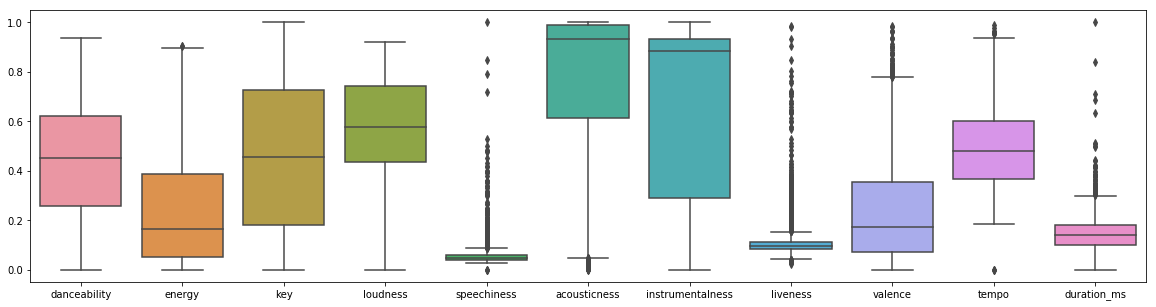

In [103]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.boxplot(data=upbeat_df.drop(["mood", "mode", "time_signature"], axis=1))
plt.show()

sns.boxplot(data=calm_df.drop(["mood", "mode", "time_signature"], axis=1))
plt.show()



### Comparison Scatter Plots

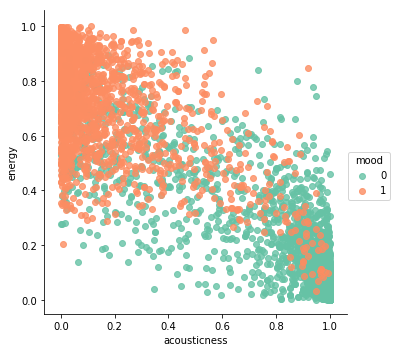

In [108]:
sns.set_palette(sns.color_palette("Set2"))
sns.lmplot(x='acousticness', y='energy', data=dataset, fit_reg=False, hue='mood')
plt.show()

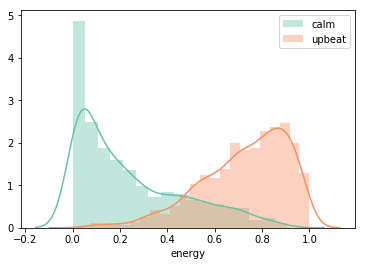

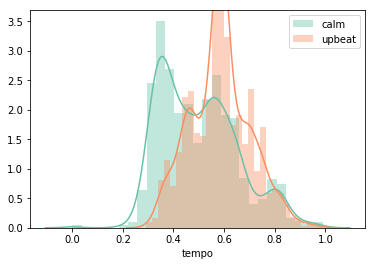

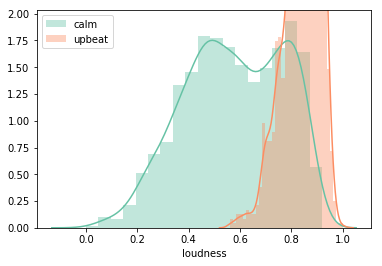

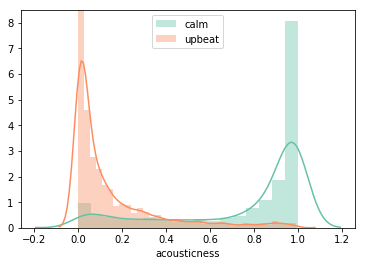

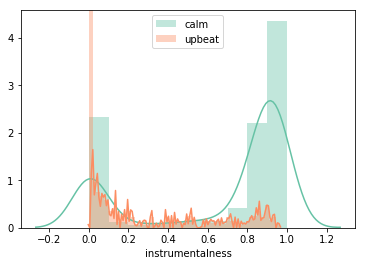

In [114]:
sns.distplot(calm_df.energy, label="calm")
sns.distplot(upbeat_df.energy, label="upbeat")
plt.legend()
plt.show()

sns.distplot(calm_df.tempo, label="calm")
sns.distplot(upbeat_df.tempo, label="upbeat")
plt.legend()
plt.show()

sns.distplot(calm_df.loudness, label="calm")
sns.distplot(upbeat_df.loudness, label="upbeat")
plt.legend()
plt.show()

sns.distplot(calm_df.acousticness, label="calm")
sns.distplot(upbeat_df.acousticness, label="upbeat")
plt.legend()
plt.show()

sns.distplot(calm_df.instrumentalness, label="calm")
sns.distplot(upbeat_df.instrumentalness, label="upbeat")
plt.legend()
plt.show()

## 5 Data Mining


| Classifier  | Correctly Classified Instances  |
|---|---|
| Naive Bayes  | 87.9552 % |
| Logistic Regression  | 88.9228 %  |
| IBK  | 85.3832 %  |
| J48  | 87.2931 %  |
| Random Tree | 89.8396 % |
| ADABoostM1  | 88.057 %  |


| |  |
|--|--|
| Upbeat Tracks |  1877 |
| Calm Tracks | 2050 |
| Total Tracks | 3927 |

### 5.1 Naive Bayes

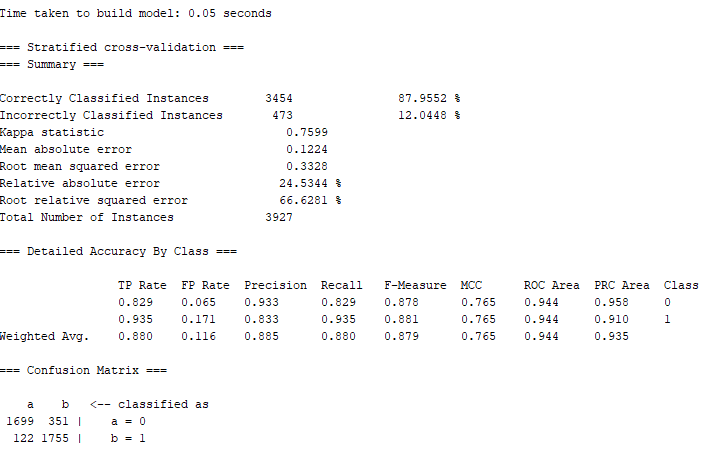

### 5.2 Trees

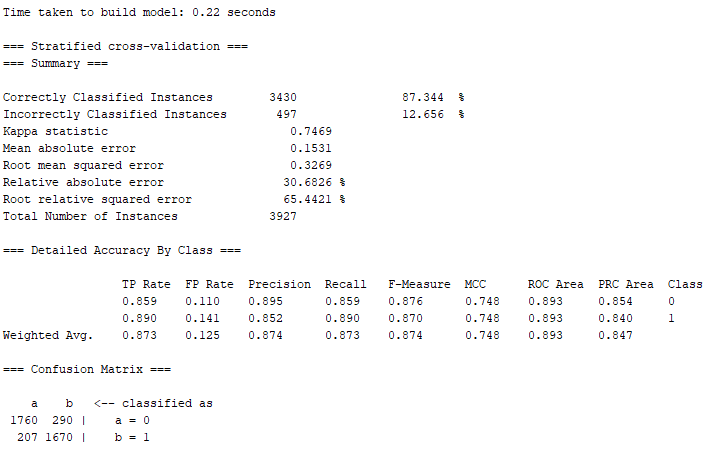
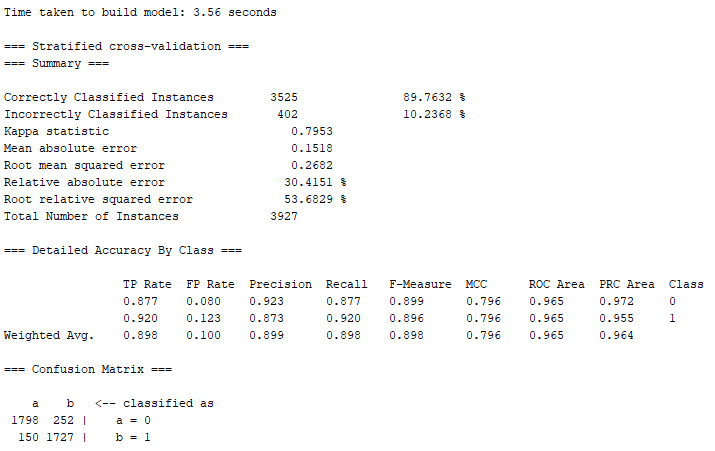

### 5.3 Logistic Regression

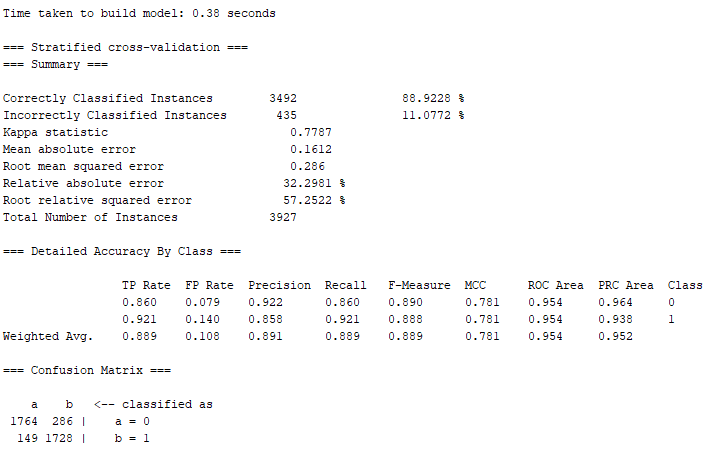

### 5.4 IBK

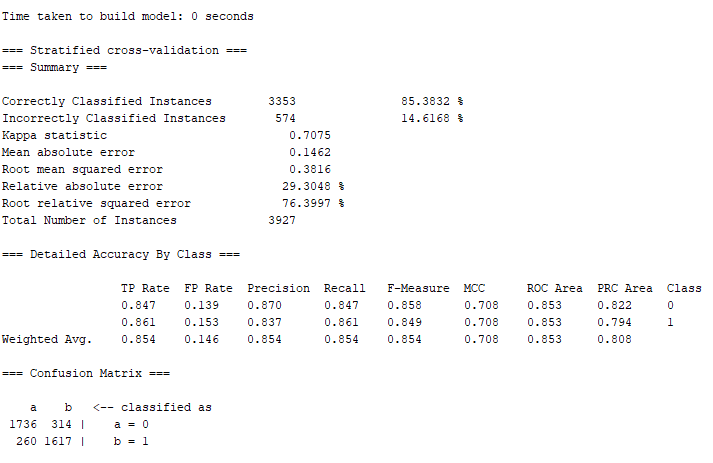

### 5.4 ADA Boost

## 6 Evaluation

## 7 Conclusion

## 8 References